# firstly, drop everything you have previously

In [1]:
scalar  drop _all
program drop _all
matrix  drop _all

# install the KPSS package

In [2]:
ssc install kpss

checking kpss consistency and verifying not already installed...
all files already exist and are up to date.


# load data into stata

In [7]:
use "~/Dropbox/Working_Directory/Python/stat_models/ARIMA_ACF/AuQuGDP.dta", clear

In [8]:
describe


Contains data from ~/Dropbox/Working_Directory/Python/stat_models/ARIMA_ACF/AuQu
> GDP.dta
  obs:           241                          
 vars:             5                          14 Sep 2020 22:56
 size:         5,302                          
--------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------
Time            int     %td                   Time
AuGDP           double  %10.0g                AuGDP
quarter         float   %9.0g                 
year            float   %9.0g                 
t               float   %tq                   
--------------------------------------------------------------------------------
Sorted by: t


# Step 1 : let's check whether we have unit root

we have 3 tests to do that : KPSS, PPERRON and ADF

* the reason I bring KPSS is because it can automatically determin how many lag terms should be included in the test via BIC
* ADF, however, cannot do that. You need to specify it yourself

In [9]:
kpss AuGDP

 
KPSS test for AuGDP
 
Maxlag = 4 chosen by Schwert criterion
Autocovariances weighted by Bartlett kernel
 
Critical values for H0: AuGDP is trend stationary
 
10%: 0.119  5% : 0.146  2.5%: 0.176  1% : 0.216
 
Lag order    Test statistic
    0           5.92
    1           2.98
    2              2
    3           1.51
    4           1.22


In [10]:
kpss S1.AuGDP

 
KPSS test for S.AuGDP
 
Maxlag = 4 chosen by Schwert criterion
Autocovariances weighted by Bartlett kernel
 
Critical values for H0: S.AuGDP is trend stationary
 
10%: 0.119  5% : 0.146  2.5%: 0.176  1% : 0.216
 
Lag order    Test statistic
    0          .0923
    1           .093
    2          .0904
    3          .0871
    4          .0896


In [11]:
pperron AuGDP


Phillips-Perron test for unit root                 Number of obs   =       240
                                                   Newey-West lags =         4

                               ---------- Interpolated Dickey-Fuller ---------
                  Test         1% Critical       5% Critical      10% Critical
               Statistic           Value             Value             Value
------------------------------------------------------------------------------
 Z(rho)            1.253           -20.267           -13.980           -11.187
 Z(t)              5.957            -3.463            -2.881            -2.571
------------------------------------------------------------------------------
MacKinnon approximate p-value for Z(t) = 1.0000


In [12]:
pperron S1.AuGDP


Phillips-Perron test for unit root                 Number of obs   =       239
                                                   Newey-West lags =         4

                               ---------- Interpolated Dickey-Fuller ---------
                  Test         1% Critical       5% Critical      10% Critical
               Statistic           Value             Value             Value
------------------------------------------------------------------------------
 Z(rho)         -234.333           -20.263           -13.978           -11.185
 Z(t)            -13.514            -3.464            -2.881            -2.571
------------------------------------------------------------------------------
MacKinnon approximate p-value for Z(t) = 0.0000


In [13]:
dfuller AuGDP


Dickey-Fuller test for unit root                   Number of obs   =       240

                               ---------- Interpolated Dickey-Fuller ---------
                  Test         1% Critical       5% Critical      10% Critical
               Statistic           Value             Value             Value
------------------------------------------------------------------------------
 Z(t)              6.103            -3.463            -2.881            -2.571
------------------------------------------------------------------------------
MacKinnon approximate p-value for Z(t) = 1.0000


In [14]:
dfuller S1.AuGDP


Dickey-Fuller test for unit root                   Number of obs   =       239

                               ---------- Interpolated Dickey-Fuller ---------
                  Test         1% Critical       5% Critical      10% Critical
               Statistic           Value             Value             Value
------------------------------------------------------------------------------
 Z(t)            -13.171            -3.464            -2.881            -2.571
------------------------------------------------------------------------------
MacKinnon approximate p-value for Z(t) = 0.0000


# All 3 tests confirm consistently that there is unit root problem on AuGDP 
# All 3 tests confirm consistently that there is no unit root problem on AuGDP after first order differencing.

# To formally work it our, let's keep differencing and see whether the unit root is really gone via ADF

In [15]:
forvalues i = 0(1)5{

  qui dfuller S`i'.AuGDP, lags(3) trend regress

  scalar p_val_order_`i' = r(p)

  if p_val_order_`i' <= 0.05{

    display "ADF test rejects H0 at order", `i'

  }
  else{

    display "ADF test does not reject H0 at order", `i'

  }

}


ADF test does not reject H0 at order 0
ADF test rejects H0 at order 1
ADF test rejects H0 at order 2
ADF test rejects H0 at order 3
ADF test rejects H0 at order 4
ADF test rejects H0 at order 5


In [16]:
scalar list

p_val_order_5 =  2.162e-08
p_val_order_4 =  1.533e-10
p_val_order_3 =  .00004064
p_val_order_2 =  1.798e-10
p_val_order_1 =  6.187e-11
p_val_order_0 =  .98548893
   schwert =          4


# now let's find the optimal order for $p$ and $q$

## in order to ease the pain of retyping the same codes hundreds of times, let's write a function to compute everything we need.

In [17]:
scalar  drop _all
program drop _all
matrix  drop _all

In [18]:
capture program drop arima_est
program define arima_est
    
	qui arima AuGDP if t<=tq(2018q4), arima(`1',`2',`3')
	
    capture confirm variable e

    if !_rc{
        drop e
    }
    qui predict e, resid
    qui wntestq e, lags(60)
    scalar test_stat_`1'_`3' =  r(stat)
    scalar df_`1'_`3'        = 60-`1'-`3'
	
    *run Ljung-Box test to see whether the residual process is a white noise
    display 
    display "-------------------------------------------"
    display "the df of Ljung-Box test is " df_`1'_`3'
    display "the Ljung-Box test statistic is " test_stat_`1'_`3'
    display "the Ljung-Box test p-value is " chi2tail(df_`1'_`3',test_stat_`1'_`3')
    display "-------------------------------------------"
    display
	
	*plot ac and pac of e simultaneously
	qui pac e, name(g1, replace) nodraw
	qui ac  e, name(g2, replace) nodraw

	graph combine g1 g2, col(1) name(combined, replace)
    
    *compute the AIC and BIC of p and q
    qui estat ic
    matrix M_`1'_`3'_IC = r(S)
    scalar aic_`1'_`3'  = M_`1'_`3'_IC[1, 5]
    scalar bic_`1'_`3'  = M_`1'_`3'_IC[1, 6]
	
	display 
	display "-------------------------------------------"
	display "the AIC for p = `1', q = `3' is " aic_`1'_`3'
	display "the BIC for p = `1', q = `3' is " bic_`1'_`3'
	display "-------------------------------------------"
	display
    
    scalar drop test_stat_`1'_`3' df_`1'_`3' 
    matrix drop M_`1'_`3'_IC
	
end

# now let's see where we shall start

## At week 6, we start from $p=q=0$ and try to complicate the model progressively. This trick is called forward selection and not recommended from times series analysis.

## Unlike week 6, we start everything backwards to avoid non-convergence of MLE. This scheme is called backwards selection and is highly recommended for times series MLE models.

## Let's first plot the ACF and PACF to see where we should start with $p$ and $q$

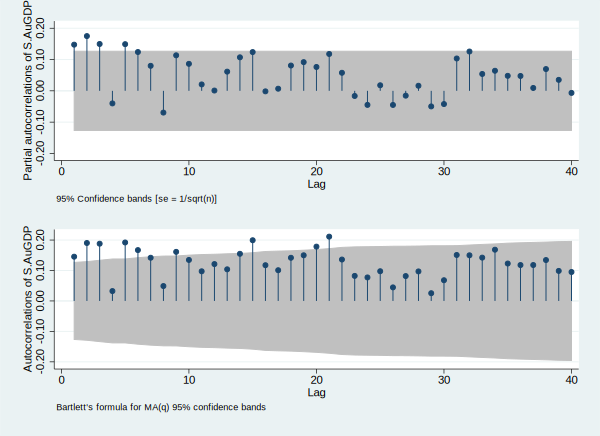

In [19]:
qui pac S1.AuGDP, name(g1, replace) nodraw
qui ac  S1.AuGDP, name(g2, replace) nodraw

graph combine g1 g2, col(1) name(combined, replace)

# It seems that $p=q=7$ is likely a good place to start with


-------------------------------------------
the df of Ljung-Box test is 46
the Ljung-Box test statistic is 34.740726
the Ljung-Box test p-value is .88783007
-------------------------------------------


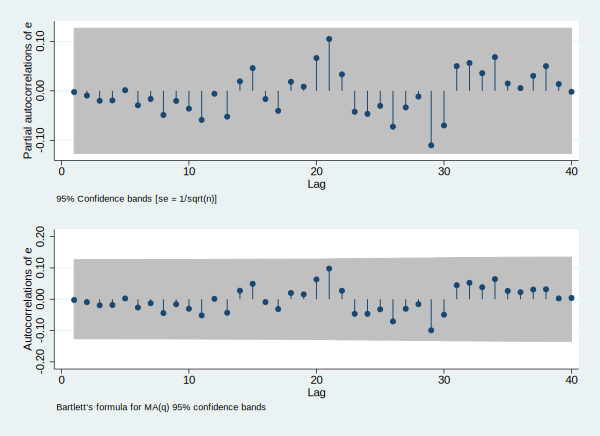



-------------------------------------------
the AIC for p = 7, q = 7 is 10648.081
the BIC for p = 7, q = 7 is 10699.975
-------------------------------------------



In [20]:
arima_est 7 1 7

When $p=q=7$, the Ljung-Box test confirms that your residual process is a white noise

$H_0 : $
* your residual process is a white noise 
* or equivalently, your linear model is complicated enough; 
* or equivalently, your linear model has fully explained all the possible linear pattern in $S1.AuGDP$

$H_1 : H_0$ is not true. 

The test statistic is a $\chi^2$ process, whose degree of freedom is the number of lag terms minus the number of parameter in your model ($p+q$ for ARIMA and $p+q+P+Q$ for SARIMA).

Let's use 5% as the sig level

# Now we start a horrible search scheme called "grid search".
* Both $p=q=7$ is complicated enough for the data. (Ljung-Box confimrs that the residual process has been squeezed into a white noise)
* now we can gradually reduce the value of $p$ and $q$ and see how Ljung-Box and IC would respond to our move 


-------------------------------------------
the df of Ljung-Box test is 47
the Ljung-Box test statistic is 35.290231
the Ljung-Box test p-value is .89533317
-------------------------------------------


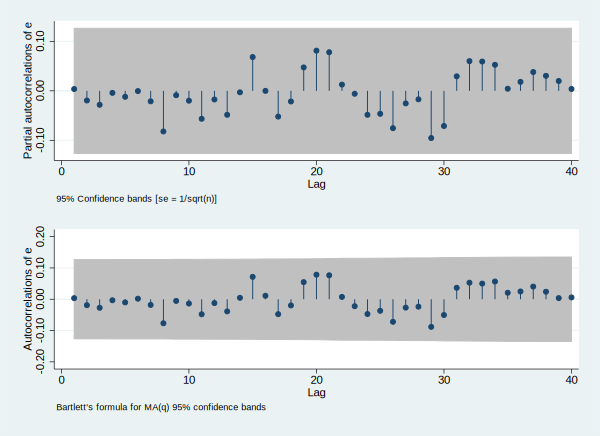



-------------------------------------------
the AIC for p = 6, q = 7 is 10644.079
the BIC for p = 6, q = 7 is 10692.513
-------------------------------------------



In [21]:
arima_est 6 1 7

# If you see "flat log likelihood encountered, cannot find uphill direction"

* Don't panic. This is quite normal in MLE since, unlike L2 error in OLS, loglikelihood is neither differentiable nor convex. As a result, quite often your model cannot be solved.

* That why we start from a complicated model and reduce it complexity gradually. If $p=q=7$ is solvable, most models with $p,q<=7$ should also be solvable

* If you follow the forward selection scheme, it is likely that you will be stuck at some value of $\tilde{p}$ and $\tilde{q}$ and all other $p$ and $q$ around $\left(\tilde{p}, \tilde{q}\right)$ are not solvable

In [22]:
arima_est 7 1 6

flat log likelihood encountered, cannot find uphill direction


r(430);



-------------------------------------------
the df of Ljung-Box test is 48
the Ljung-Box test statistic is 35.229743
the Ljung-Box test p-value is .91485993
-------------------------------------------


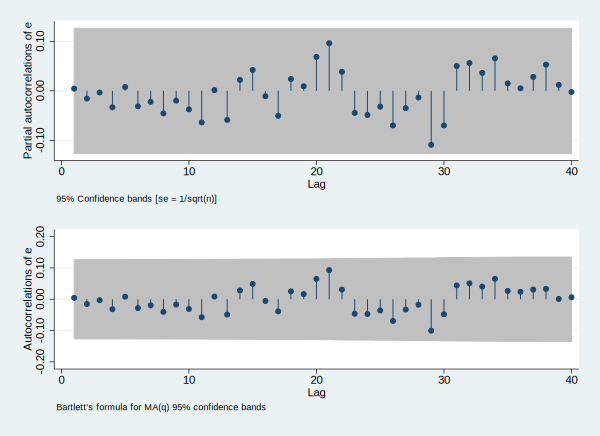



-------------------------------------------
the AIC for p = 6, q = 6 is 10644.41
the BIC for p = 6, q = 6 is 10689.385
-------------------------------------------



In [23]:
arima_est 6 1 6


-------------------------------------------
the df of Ljung-Box test is 49
the Ljung-Box test statistic is 37.106013
the Ljung-Box test p-value is .89369656
-------------------------------------------


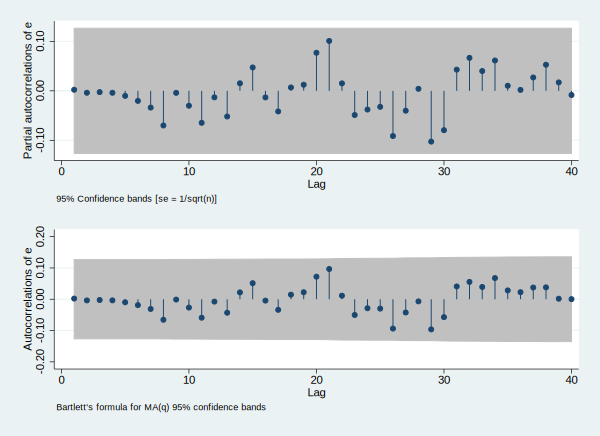



-------------------------------------------
the AIC for p = 6, q = 5 is 10642.853
the BIC for p = 6, q = 5 is 10684.368
-------------------------------------------



In [159]:
arima_est 6 1 5


-------------------------------------------
the df of Ljung-Box test is 49
the Ljung-Box test statistic is 37.210747
the Ljung-Box test p-value is .89134148
-------------------------------------------


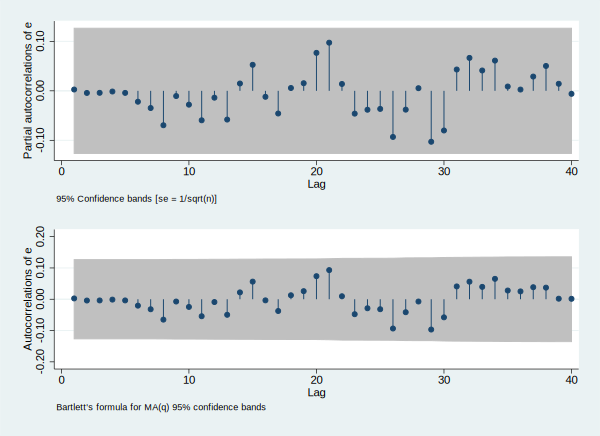



-------------------------------------------
the AIC for p = 5, q = 6 is 10642.851
the BIC for p = 5, q = 6 is 10684.366
-------------------------------------------



In [160]:
arima_est 5 1 6

In [161]:
arima_est 5 1 5

flat log likelihood encountered, cannot find uphill direction


r(430);



-------------------------------------------
the df of Ljung-Box test is 51
the Ljung-Box test statistic is 37.075255
the Ljung-Box test p-value is .92803573
-------------------------------------------


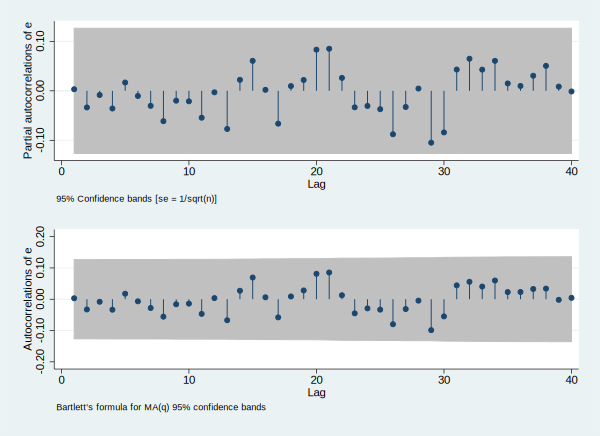



-------------------------------------------
the AIC for p = 4, q = 5 is 10639.903
the BIC for p = 4, q = 5 is 10674.499
-------------------------------------------



In [162]:
arima_est 4 1 5


-------------------------------------------
the df of Ljung-Box test is 51
the Ljung-Box test statistic is 37.013801
the Ljung-Box test p-value is .92906469
-------------------------------------------


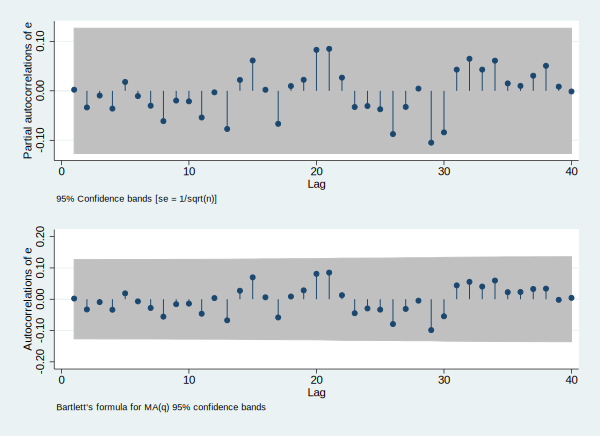



-------------------------------------------
the AIC for p = 5, q = 4 is 10639.907
the BIC for p = 5, q = 4 is 10674.503
-------------------------------------------



In [163]:
arima_est 5 1 4


-------------------------------------------
the df of Ljung-Box test is 52
the Ljung-Box test statistic is 36.762572
the Ljung-Box test p-value is .94568927
-------------------------------------------


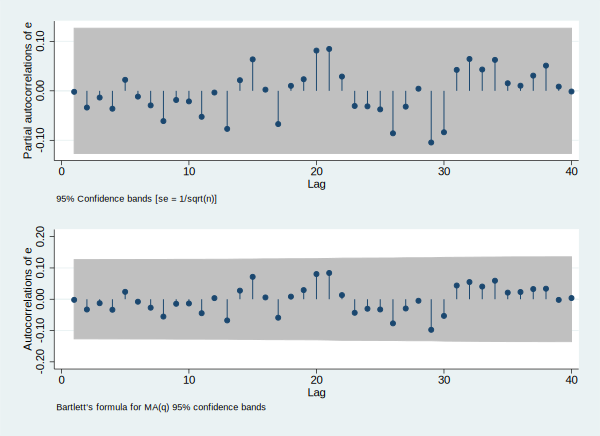



-------------------------------------------
the AIC for p = 4, q = 4 is 10637.925
the BIC for p = 4, q = 4 is 10669.061
-------------------------------------------



In [164]:
arima_est 4 1 4


-------------------------------------------
the df of Ljung-Box test is 53
the Ljung-Box test statistic is 37.286773
the Ljung-Box test p-value is .9498617
-------------------------------------------


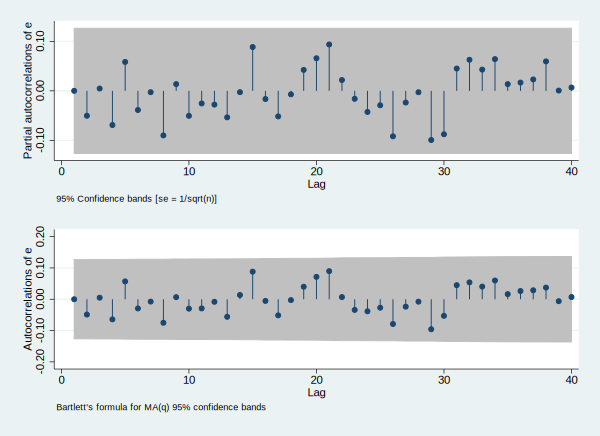



-------------------------------------------
the AIC for p = 3, q = 4 is 10643.196
the BIC for p = 3, q = 4 is 10674.332
-------------------------------------------



In [165]:
arima_est 3 1 4


-------------------------------------------
the df of Ljung-Box test is 53
the Ljung-Box test statistic is 37.473272
the Ljung-Box test p-value is .94744799
-------------------------------------------


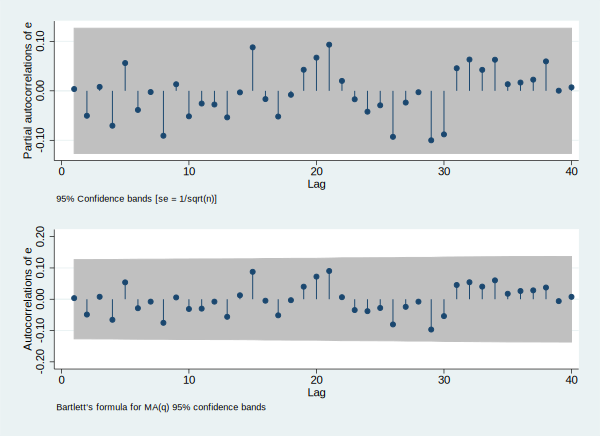



-------------------------------------------
the AIC for p = 4, q = 3 is 10643.229
the BIC for p = 4, q = 3 is 10674.365
-------------------------------------------



In [166]:
arima_est 4 1 3


-------------------------------------------
the df of Ljung-Box test is 54
the Ljung-Box test statistic is 38.154812
the Ljung-Box test p-value is .949514
-------------------------------------------


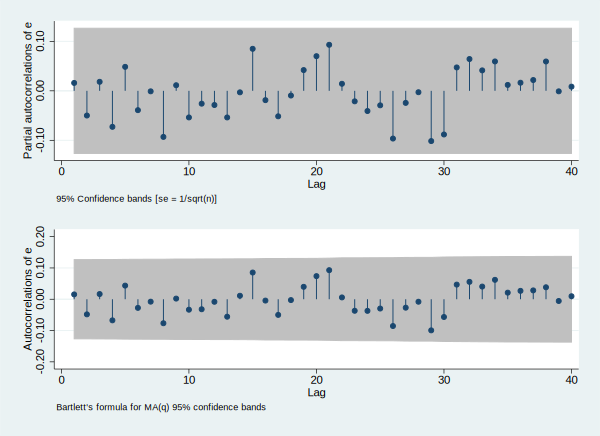



-------------------------------------------
the AIC for p = 3, q = 3 is 10641.34
the BIC for p = 3, q = 3 is 10669.016
-------------------------------------------



In [167]:
arima_est 3 1 3


-------------------------------------------
the df of Ljung-Box test is 55
the Ljung-Box test statistic is 44.671739
the Ljung-Box test p-value is .83879375
-------------------------------------------


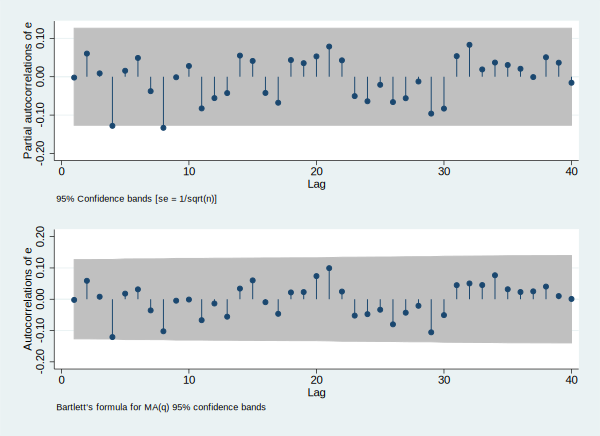



-------------------------------------------
the AIC for p = 2, q = 3 is 10640.625
the BIC for p = 2, q = 3 is 10661.382
-------------------------------------------



In [168]:
arima_est 2 1 3


-------------------------------------------
the df of Ljung-Box test is 55
the Ljung-Box test statistic is 44.894078
the Ljung-Box test p-value is .83277665
-------------------------------------------


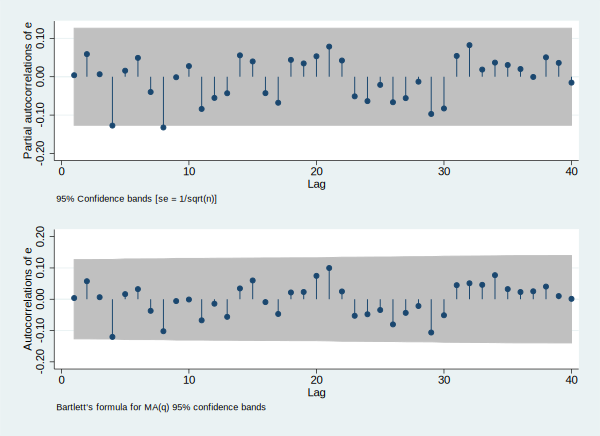



-------------------------------------------
the AIC for p = 3, q = 2 is 10640.557
the BIC for p = 3, q = 2 is 10661.314
-------------------------------------------



In [169]:
arima_est 3 1 2

In [170]:
arima_est 2 1 2

flat log likelihood encountered, cannot find uphill direction


r(430);



-------------------------------------------
the df of Ljung-Box test is 57
the Ljung-Box test statistic is 45.021977
the Ljung-Box test p-value is .87453196
-------------------------------------------


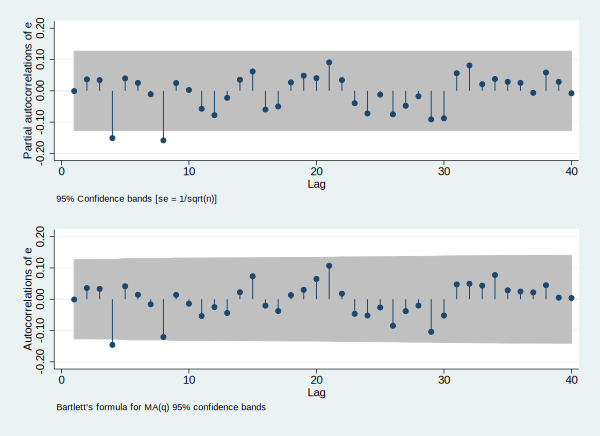



-------------------------------------------
the AIC for p = 1, q = 2 is 10643.401
the BIC for p = 1, q = 2 is 10660.698
-------------------------------------------



In [171]:
arima_est 1 1 2


-------------------------------------------
the df of Ljung-Box test is 57
the Ljung-Box test statistic is 45.072957
the Ljung-Box test p-value is .87337472
-------------------------------------------


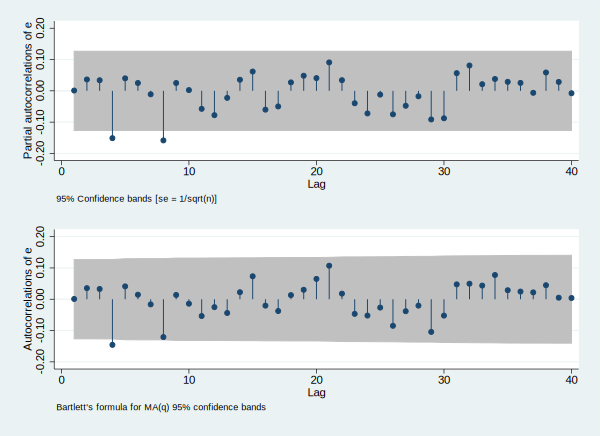



-------------------------------------------
the AIC for p = 2, q = 1 is 10643.393
the BIC for p = 2, q = 1 is 10660.691
-------------------------------------------



In [172]:
arima_est 2 1 1


-------------------------------------------
the df of Ljung-Box test is 58
the Ljung-Box test statistic is 44.436986
the Ljung-Box test p-value is .90494437
-------------------------------------------


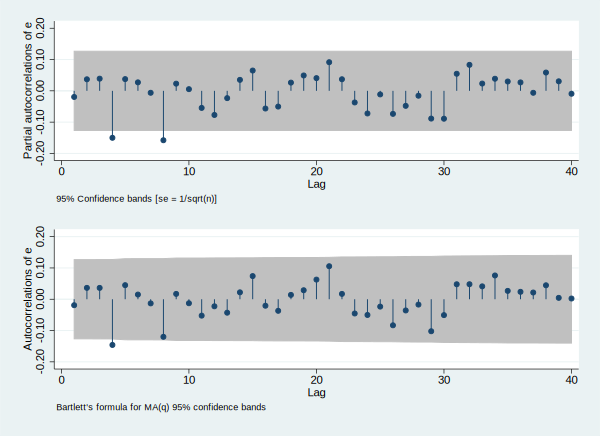



-------------------------------------------
the AIC for p = 1, q = 1 is 10641.49
the BIC for p = 1, q = 1 is 10655.328
-------------------------------------------



In [173]:
arima_est 1 1 1


-------------------------------------------
the df of Ljung-Box test is 59
the Ljung-Box test statistic is 140.12935
the Ljung-Box test p-value is 1.495e-08
-------------------------------------------


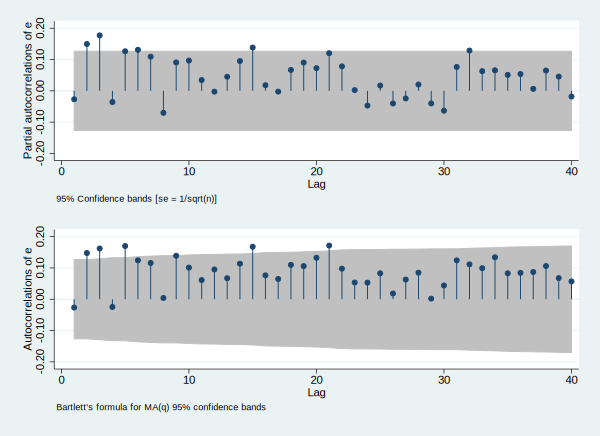



-------------------------------------------
the AIC for p = 1, q = 0 is 10663.986
the BIC for p = 1, q = 0 is 10674.365
-------------------------------------------



In [174]:
arima_est 1 1 0


-------------------------------------------
the df of Ljung-Box test is 59
the Ljung-Box test statistic is 164.39782
the Ljung-Box test p-value is 6.959e-12
-------------------------------------------


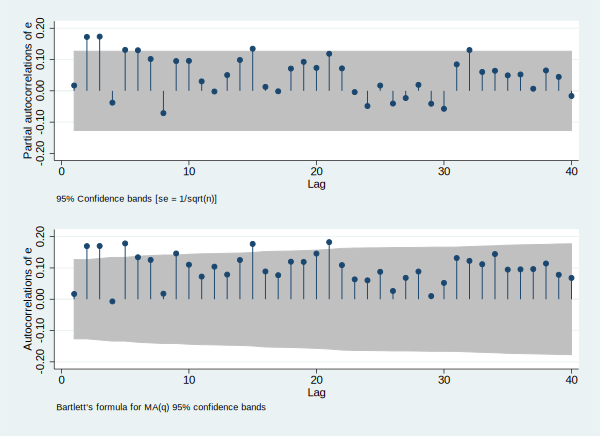



-------------------------------------------
the AIC for p = 0, q = 1 is 10665.316
the BIC for p = 0, q = 1 is 10675.695
-------------------------------------------



In [175]:
arima_est 0 1 1


-------------------------------------------
the df of Ljung-Box test is 60
the Ljung-Box test statistic is 233.1068
the Ljung-Box test p-value is 3.068e-22
-------------------------------------------


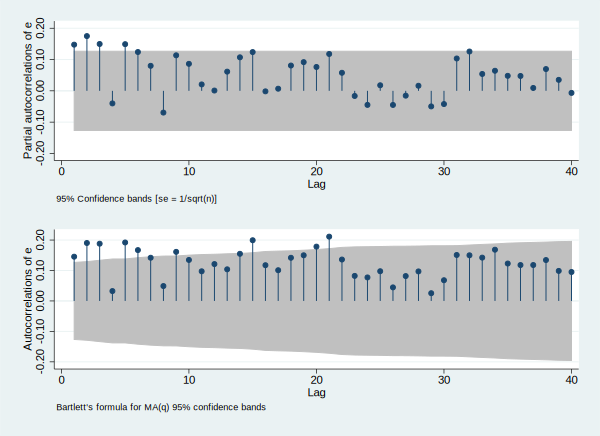



-------------------------------------------
the AIC for p = 0, q = 0 is 10667.246
the BIC for p = 0, q = 0 is 10674.165
-------------------------------------------



In [176]:
arima_est 0 1 0

# Now all the search results have been computed, let's list them all and see which is optimal

In [177]:
scalar list

   bic_0_0 =  10674.165
   aic_0_0 =  10667.246
   bic_0_1 =  10675.695
   aic_0_1 =  10665.316
   bic_1_0 =  10674.365
   aic_1_0 =  10663.986
   bic_1_1 =  10655.328
   aic_1_1 =   10641.49
   bic_2_1 =  10660.691
   aic_2_1 =  10643.393
   bic_1_2 =  10660.698
   aic_1_2 =  10643.401
   bic_3_2 =  10661.314
   aic_3_2 =  10640.557
   bic_2_3 =  10661.382
   aic_2_3 =  10640.625
   bic_3_3 =  10669.016
   aic_3_3 =   10641.34
   bic_4_3 =  10674.365
   aic_4_3 =  10643.229
   bic_3_4 =  10674.332
   aic_3_4 =  10643.196
   bic_4_4 =  10669.061
   aic_4_4 =  10637.925
   bic_5_4 =  10674.503
   aic_5_4 =  10639.907
   bic_4_5 =  10674.499
   aic_4_5 =  10639.903
   bic_5_6 =  10684.366
   aic_5_6 =  10642.851
   bic_6_5 =  10684.368
   aic_6_5 =  10642.853
   bic_6_6 =  10689.385
   aic_6_6 =   10644.41
   bic_6_7 =  10692.513
   aic_6_7 =  10644.079
   bic_7_7 =  10699.975
   aic_7_7 =  10648.081


# $p=q=1$ is optimal in terms of BIC

In [25]:
use "~/Dropbox/Working_Directory/Python/stat_models/ARIMA_ACF/AuQuGDP.dta", clear

arima AuGDP if t<=tq(2018q4), arima(1, 1, 1)

predict yhat_1_1
predict ehat_1_1, res




(setting optimization to BHHH)
Iteration 0:   log likelihood = -5330.1483  
Iteration 1:   log likelihood = -5323.8048  
Iteration 2:   log likelihood = -5319.5099  
Iteration 3:   log likelihood = -5317.0978  
Iteration 4:   log likelihood = -5316.7922  
(switching optimization to BFGS)
BFGS stepping has contracted, resetting BFGS Hessian (0)
Iteration 5:   log likelihood = -5316.7842  
Iteration 6:   log likelihood = -5316.7705  (backed up)
Iteration 7:   log likelihood = -5316.7557  (backed up)
Iteration 8:   log likelihood = -5316.7547  
Iteration 9:   log likelihood = -5316.7546  
Iteration 10:  log likelihood = -5316.7546  
Iteration 11:  log likelihood = -5316.7546  (backed up)
Iteration 12:  log likelihood = -5316.7546  (backed up)
Iteration 13:  log likelihood = -5316.7546  (backed up)
Iteration 14:  log likelihood = -5316.7546  (backed up)
(switching optimization to BHHH)
Iteration 15:  log likelihood = -5316.7546  
Iteration 16:  log likelihood = -5316.7522  
Iteration 17

# $p=q=4$ is optimal in terms of AIC

In [26]:
arima AuGDP if t<=tq(2018q4), arima(4, 1, 4)

predict yhat_4_4
predict ehat_4_4, res



(setting optimization to BHHH)
Iteration 0:   log likelihood = -5329.9334  
Iteration 1:   log likelihood = -5323.9443  
Iteration 2:   log likelihood = -5323.8289  
Iteration 3:   log likelihood = -5323.2391  (backed up)
Iteration 4:   log likelihood = -5321.2453  
(switching optimization to BFGS)
BFGS stepping has contracted, resetting BFGS Hessian (0)
Iteration 5:   log likelihood = -5312.9444  
Iteration 6:   log likelihood = -5312.5232  (backed up)
Iteration 7:   log likelihood = -5312.4138  (backed up)
Iteration 8:   log likelihood = -5312.3818  (backed up)
Iteration 9:   log likelihood = -5312.3657  (backed up)
Iteration 10:  log likelihood = -5312.1687  (backed up)
Iteration 11:  log likelihood = -5312.1286  (backed up)
Iteration 12:  log likelihood = -5311.7848  (backed up)
Iteration 13:  log likelihood =  -5311.352  
Iteration 14:  log likelihood = -5310.9998  
(switching optimization to BHHH)
Iteration 15:  log likelihood = -5310.3701  
Iteration 16:  log likelihood = -531

# let's compare the prediction and residual

In [27]:
list t S1.AuGDP yhat_1_1 yhat_4_4 ehat_1_1 ehat_4_4 if t>=tq(2018q4)


     +-------------------------------------------------------------------+
     |                   S.                                              |
     |      t        AuGDP   yhat_1_1   yhat_4_4    ehat_1_1    ehat_4_4 |
     |-------------------------------------------------------------------|
236. | 2018q4    7.860e+08   2.64e+09   2.83e+09   -1.85e+09   -2.04e+09 |
237. | 2019q1    2.127e+09   2.55e+09   2.28e+09   -4.19e+08   -1.56e+08 |
238. | 2019q2    2.889e+09   2.52e+09   2.41e+09    3.68e+08    4.77e+08 |
239. | 2019q3    2.635e+09   2.53e+09   2.33e+09    1.01e+08    3.01e+08 |
240. | 2019q4    2.489e+09   2.53e+09   3.00e+09   -4.44e+07   -5.13e+08 |
     |-------------------------------------------------------------------|
241. | 2020q1   -1.469e+09   2.53e+09   2.34e+09   -4.00e+09   -3.80e+09 |
     +-------------------------------------------------------------------+


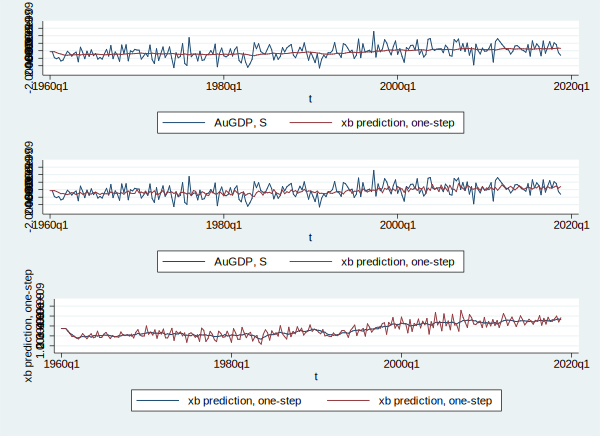

In [28]:
qui tsline S1.AuGDP yhat_1_1 if t<=tq(2018q4), name(g1, replace) nodraw
qui tsline S1.AuGDP yhat_4_4 if t<=tq(2018q4), name(g2, replace) nodraw
qui tsline yhat_1_1 yhat_4_4 if t<=tq(2018q4), name(g3, replace) nodraw

graph combine g1 g2 g3, col(1) name(combined, replace)

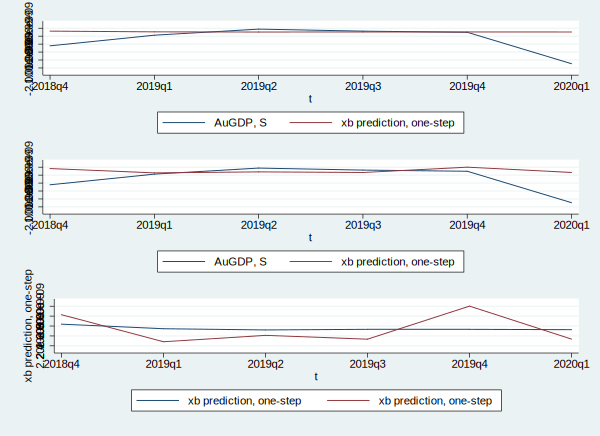

In [29]:
qui tsline S1.AuGDP yhat_1_1 if t>=tq(2018q4), name(g1, replace) nodraw
qui tsline S1.AuGDP yhat_4_4 if t>=tq(2018q4), name(g2, replace) nodraw
qui tsline yhat_1_1 yhat_4_4 if t>=tq(2018q4), name(g3, replace) nodraw

graph combine g1 g2 g3, col(1) name(combined, replace)

# What if you set $d=0$ instead of $1$ ?

# ignoring the unit root problem may lead your ARMA model unsolvable

In [183]:
qui arima AuGDP if t<=tq(2018q4), arima(1, 0, 1)


flat log likelihood encountered, cannot find uphill direction


r(430);
r(430);


In [184]:
predict y_arma_1_1

(option xb assumed; fitted values)
variable __000053 not found


r(111);


In [181]:
qui arima AuGDP if t<=tq(2018q4), arima(4, 0, 4)


flat log likelihood encountered, cannot find uphill direction


r(430);
r(430);


In [182]:
predict y_arma_4_4

(option xb assumed; fitted values)
variable __000051 not found


r(111);


In [2]:
!rm -rf W5_Stata.html
!jupyter nbconvert --to html W5_Stata.ipynb





[NbConvertApp] Converting notebook W5_Stata.ipynb to html
[NbConvertApp] Writing 1739169 bytes to W5_Stata.html
